# Solução desenvolvida

## Preparação de ambiente

In [1]:
!pip3 install -r requirements.txt

In [2]:
# caso instalar algo novo
!pip3 freeze > requirements.txt

In [15]:
# imports
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

## Definições e declarações

In [2]:
# Estados
STATE_HIGH = "Bateria Alta"
STATE_LOW = "Bateria Baixa"

# Ações
ACTION_SEARCH = "Procurar"
ACTION_WAIT = "Esperar"
ACTION_RECHARGE = "Recarregar"

Definindo abaixo as probabilidades de transição:

In [3]:
# Probabilidades e Recompensas
ALPHA_PROB = 0.9  # Probabilidade de a bateria permanecer alta ao procurar
BETA_PROB = 0.7   # Probabilidade de a bateria permanecer baixa ao procurar
R_SEARCH = 8      # Recompensa por procurar (deve ser > R_WAIT)
R_WAIT = 2        # Recompensa por esperar
R_RESCUE = -3     # Penalidade por precisar de resgate
R_RECHARGE = 0    # Recompensa por recarregar

Parâmetros de treinamento e outras variáveis globais:

In [4]:
# Parâmetros
LEARNING_RATE = 0.1            # Taxa de aprendizado (alpha no TD)
NUM_EPOCHS = 100               # Número de épocas de treinamento
STEPS_PER_EPOCH = 1000         # Passos de tempo por época

# Diretório
DIR = "files/"

Criando classes para modelar o problema:

In [78]:
# ------------ Classes ------------

class Environment:
    """
    Simula o ambiente do robô de reciclagem.
    Gerencia as transições de estado e as recompensas com base nas ações do robô.
    """
    def get_available_actions(self, state):
        """ Retorna as ações possíveis para um dado estado. """
        if state == STATE_HIGH:
            return [ACTION_SEARCH, ACTION_WAIT]
        else: # STATE_LOW
            return [ACTION_SEARCH, ACTION_WAIT, ACTION_RECHARGE]

    def step(self, state, action):
        """
        Executa uma ação e retorna o próximo estado e a recompensa.
        A lógica de transição é baseada nas probabilidades alfa e beta.
        """
        if state == STATE_HIGH:
            if action == ACTION_SEARCH:
                # Transição estocástica ao procurar com bateria alta
                if np.random.rand() < ALPHA_PROB:
                    next_state = STATE_HIGH
                else:
                    next_state = STATE_LOW
                return next_state, R_SEARCH
            elif action == ACTION_WAIT:
                # Ficar em espera mantém o estado e dá uma recompensa menor
                return STATE_HIGH, R_WAIT

        elif state == STATE_LOW:
            if action == ACTION_RECHARGE:
                # Recarregar sempre leva ao estado de bateria alta
                return STATE_HIGH, R_RECHARGE
            elif action == ACTION_WAIT:
                 # Ficar em espera mantém o estado de bateria baixa
                return STATE_LOW, R_WAIT
            elif action == ACTION_SEARCH:
                # Procurar com bateria baixa tem risco de precisar de resgate
                if np.random.rand() < 1-BETA_PROB:
                    # Acabou a bateria e o robô foi resgatado
                    return STATE_HIGH, R_RESCUE
                else:
                    # Continua procurando com bateria baixa
                    return STATE_LOW, R_SEARCH

        # Caso uma ação inválida seja fornecida
        raise ValueError(f"Ação '{action}' inválida para o estado '{state}'")


class AgentTD:
    """
    Agente que usa TD(0) para avaliação e melhora a política de forma explícita.
    """
    def __init__(self, discount_factor, epsilon, learning_rate=LEARNING_RATE,):
        self.state_values = defaultdict(float)  # Armazena V(s)
        self.policy = {
            # Inicia com uma política aleatória
            STATE_HIGH: np.random.choice([ACTION_SEARCH, ACTION_WAIT]),
            STATE_LOW: np.random.choice([ACTION_SEARCH, ACTION_WAIT, ACTION_RECHARGE])
        }
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.environment = Environment()

    def choose_action(self, state):
        """
        Escolhe uma ação baseada na política atual (com exploração epsilon-greedy).
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.environment.get_available_actions(state))
        else:
            return self.policy[state]

    def update(self, state, reward, next_state):
        """
        PASSO DE AVALIAÇÃO: Atualiza o valor do estado V(s) usando a regra do TD(0).
        V(s) <- V(s) + lr * [R + gamma * V(s') - V(s)]
        """
        td_target = reward + self.gamma * self.state_values[next_state]
        td_error = td_target - self.state_values[state]
        self.state_values[state] += self.lr * td_error

    def improve_policy(self):
        """
        PASSO DE MELHORA: Atualiza a política para ser gananciosa em relação aos valores de estado atuais.
        Para cada estado, escolhe a ação que maximiza a recompensa esperada.
        """
        policy_stable = True
        for state in [STATE_HIGH, STATE_LOW]:
            old_action = self.policy[state]

            action_values = {}
            for action in self.environment.get_available_actions(state):
                # Calcula o valor esperado para cada ação (usando o modelo do ambiente)
                if state == STATE_HIGH and action == ACTION_SEARCH:
                    expected_value = ALPHA_PROB * (R_SEARCH + self.gamma * self.state_values[STATE_HIGH]) + \
                                     (1 - ALPHA_PROB) * (R_SEARCH + self.gamma * self.state_values[STATE_LOW])
                elif state == STATE_HIGH and action == ACTION_WAIT:
                    expected_value = R_WAIT + self.gamma * self.state_values[STATE_HIGH]
                elif state == STATE_LOW and action == ACTION_RECHARGE:
                    expected_value = R_RECHARGE + self.gamma * self.state_values[STATE_HIGH]
                elif state == STATE_LOW and action == ACTION_WAIT:
                    expected_value = R_WAIT + self.gamma * self.state_values[STATE_LOW]
                elif state == STATE_LOW and action == ACTION_SEARCH:
                    expected_value = BETA_PROB * (R_RESCUE + self.gamma * self.state_values[STATE_HIGH]) + \
                                     (1 - BETA_PROB) * (R_SEARCH + self.gamma * self.state_values[STATE_LOW])
                action_values[action] = expected_value

            # Escolhe a melhor ação
            best_action = max(action_values, key=action_values.get)
            self.policy[state] = best_action

            if old_action != best_action:
                policy_stable = False

        return policy_stable

    def save_policy(self, filename="policy_td0.pkl"):
        with open(filename, 'wb') as f:
            pickle.dump({'policy': self.policy, 'values': self.state_values}, f)
        print(f"Política salva em {filename}")


class AgentQ:
    """
    O agente que aprende a política ótima usando Q-learning (um método TD).
    """
    def __init__(self, discount_factor, epsilon, learning_rate=LEARNING_RATE):
        self.q_values = {}  # Dicionário para armazenar os valores Q(s, a)
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.environment = Environment()

    def get_q_value(self, state, action):
        """ Acessa o valor Q para um par (estado, ação), retornando 0 se não existir. """
        return self.q_values.get((state, action), 0.0)

    def choose_action(self, state):
        """
        Escolhe uma ação usando uma política epsilon-greedy.
        - Com probabilidade (1 - epsilon), escolhe a melhor ação (explotação).
        - Com probabilidade epsilon, escolhe uma ação aleatória (exploração).
        """
        available_actions = self.environment.get_available_actions(state)
        if np.random.rand() < self.epsilon:
            # Exploração: escolhe uma ação aleatória
            return np.random.choice(available_actions)
        else:
            # Explotação: escolhe a melhor ação com base nos valores Q
            q_vals = [self.get_q_value(state, a) for a in available_actions]
            return available_actions[np.argmax(q_vals)]

    def update(self, state, action, reward, next_state):
        """
        Atualiza o valor Q para o par (estado, ação) usando a regra do Q-learning.
        Q(s, a) <- Q(s, a) + lr * [R + gamma * max_a'(Q(s', a')) - Q(s, a)]
        """
        # Encontra o valor Q máximo para o próximo estado
        next_available_actions = self.environment.get_available_actions(next_state)
        max_next_q = max([self.get_q_value(next_state, a) for a in next_available_actions])

        # Calcula o TD target e o erro
        td_target = reward + self.gamma * max_next_q
        td_error = td_target - self.get_q_value(state, action)

        # Atualiza o valor Q
        new_q_value = self.get_q_value(state, action) + self.lr * td_error
        self.q_values[(state, action)] = new_q_value

    def save_policy(self, filename="policy_q.pkl"):
        """ Salva o dicionário de valores Q em um arquivo. """
        with open(filename, 'wb') as f:
            pickle.dump(self.q_values, f)
        print(f"Política salva em {filename}")

    def load_policy(self, filename="policy.pkl"):
        """ Carrega o dicionário de valores Q de um arquivo. """
        with open(filename, 'rb') as f:
            self.q_values = pickle.load(f)
        print(f"Política carregada de {filename}")



# ------------ Funções auxiliares ------------

def train(discount_factor, epsilon, algorithm, reward_file = "rewards.txt"):
    """
    Função principal para treinar o agente.
    """
    if algorithm == "Q":
        agent = AgentQ(discount_factor=discount_factor, epsilon=epsilon)
    elif algorithm == "TD":
        agent = AgentTD(discount_factor=discount_factor, epsilon=epsilon)
    env = Environment()
    total_rewards_per_epoch = []

    # Abre o arquivo para salvar as recompensas
    with open(DIR + reward_file, 'w') as f_rewards:
        print("Iniciando o treinamento...")
        for epoch in range(NUM_EPOCHS):
            current_state = STATE_HIGH  # Robô sempre começa com bateria alta
            total_epoch_reward = 0

            for step in range(STEPS_PER_EPOCH):
                # 1. Agente escolhe uma ação
                action = agent.choose_action(current_state)

                # 2. Ambiente retorna o próximo estado e a recompensa
                next_state, reward = env.step(current_state, action)

                # 3. Agente atualiza seus valores
                if algorithm == "Q":
                    agent.update(current_state, action, reward, next_state)
                elif algorithm == "TD":
                    agent.update(current_state, reward, next_state)

                # 4. Atualiza o estado e acumula a recompensa
                current_state = next_state
                total_epoch_reward += reward

            # Salva e imprime o progresso
            total_rewards_per_epoch.append(total_epoch_reward)
            f_rewards.write(f"{total_epoch_reward}\n")

            if (epoch + 1) % 10 == 0:
                print(f"Época {epoch + 1}/{NUM_EPOCHS} | Recompensa Total: {total_epoch_reward}")

            if algorithm == "TD":
                policy_stable = agent.improve_policy()
                # if policy_stable:
                #     print(f"Política estabilizou na iteração {step+1}.")
                #     break
    
    agent.save_policy()
    print("Treinamento concluído.")
    if algorithm == "TD":
        return agent.policy
    elif algorithm == "Q":
        return agent.q_values

def plot_rewards(gamma, epsilon, algorithm, reward_file='rewards.txt', dir = "figs/", name="rewards_plot.png"):
    """
    Lê o arquivo de recompensas e plota a curva de aprendizado.
    """
    if algorithm == "Q":
        alg = "Q-Learning"
    elif algorithm == "TD":
        alg = "TD(0)"
    rewards = np.loadtxt(DIR + reward_file)
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(rewards) + 1), rewards, marker='o', linestyle='-')
    plt.title(f"Recompensa Total Acumulada por Época\n{alg} " + r"com $\gamma = {0}, \varepsilon = {1}$".format(gamma, epsilon))
    plt.xlabel("Época")
    plt.ylabel("Recompensa Total")
    plt.grid(True)
    plt.savefig(dir+name)
    print(f"Gráfico de recompensas salvo em '{dir + name}'")

def plot_policy_heatmap(values, gamma, epsilon, algorithm, dir = "figs/", name="policy_heatmap.png"):
    """
    Cria um heatmap para visualizar a política ótima aprendida.
    """
    # Constrói a matriz da política ótima encontrada
    states = {STATE_HIGH: 0, STATE_LOW: 1}
    actions = {ACTION_SEARCH: 0, ACTION_WAIT: 1, ACTION_RECHARGE: 2}
    if algorithm == "Q":
        policy_matrix = np.full((2,3),np.nan)
        for i in values.keys():
            policy_matrix[states[i[0]], actions[i[1]]] = values[i]
    elif algorithm == "TD":
        policy_matrix = np.zeros((2,3))
        for i in values.keys():
            policy_matrix[[states[i]], actions[values[i]]] = 1.0
        
    # Cria o heatmap
    plt.figure(figsize=(10, 5))

    if algorithm == "Q":
        label = "Valor Q da ação Ótima"
        alg = "Q-Learning"
    elif algorithm == "TD":
        label = "Probabilidade de tomar cada ação"
        alg = "TD(0)"

    ax = sns.heatmap(
        policy_matrix,
        annot=True,
        fmt=".2f",
        cmap="flare",
        xticklabels=actions.keys(),
        yticklabels=states.keys(),
        linewidths=.5,
        cbar_kws={'label': label}
    )


    ax.set_title(f"Política Ótima do Robô de Reciclagem\n{alg} " + r"com $\gamma = {0}, \varepsilon = {1}$".format(gamma, epsilon), fontsize=16)
    plt.xlabel("Ações", fontsize=12)
    plt.ylabel("Estados", fontsize=12)
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.savefig(dir+name)
    print(F"Heatmap da política salvo em '{dir + name}'")

## Treinando os modelos e testando

Rodando para vários hiperparâmetros e anotando heatmaps e rewards.

Testando:
- epsilon-greedy vs greedy
- efeito de variar gamma

### Usando TD(0):

#### a) $\varepsilon$-greedy vs greedy


##### i. $\varepsilon$-greedy com $\varepsilon = 0.1$ e $\gamma = 0.9$

Iniciando o treinamento...
Época 10/100 | Recompensa Total: 7061
Época 20/100 | Recompensa Total: 6944
Época 30/100 | Recompensa Total: 6966
Época 40/100 | Recompensa Total: 6978
Época 50/100 | Recompensa Total: 6954
Época 60/100 | Recompensa Total: 6935
Época 70/100 | Recompensa Total: 7000
Época 80/100 | Recompensa Total: 7008
Época 90/100 | Recompensa Total: 6934
Época 100/100 | Recompensa Total: 6872
Política salva em policy_td0.pkl
Treinamento concluído.
Gráfico de recompensas salvo em 'figs/rewards_plot_TD_1.png'
Heatmap da política salvo em 'figs/heatmap_TD_1.png'


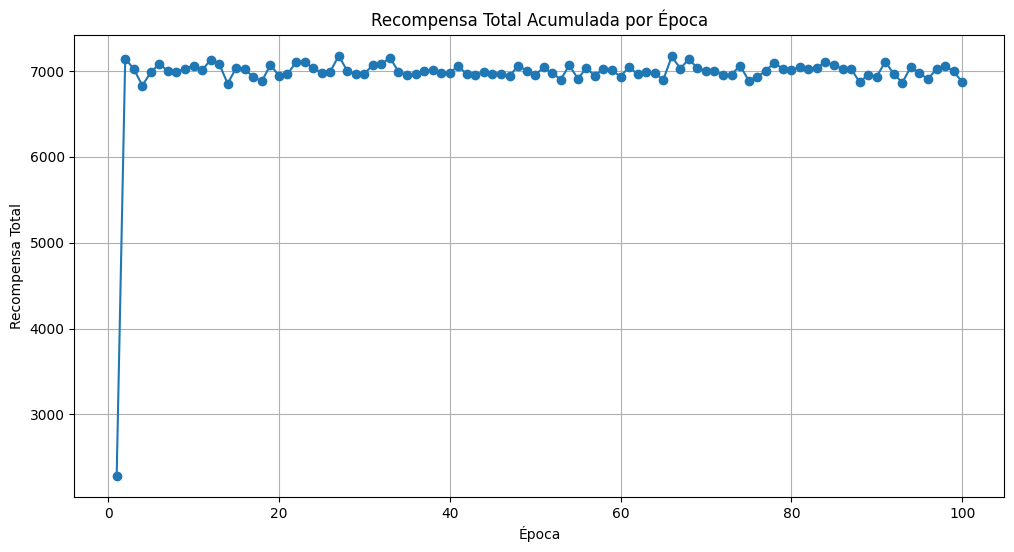

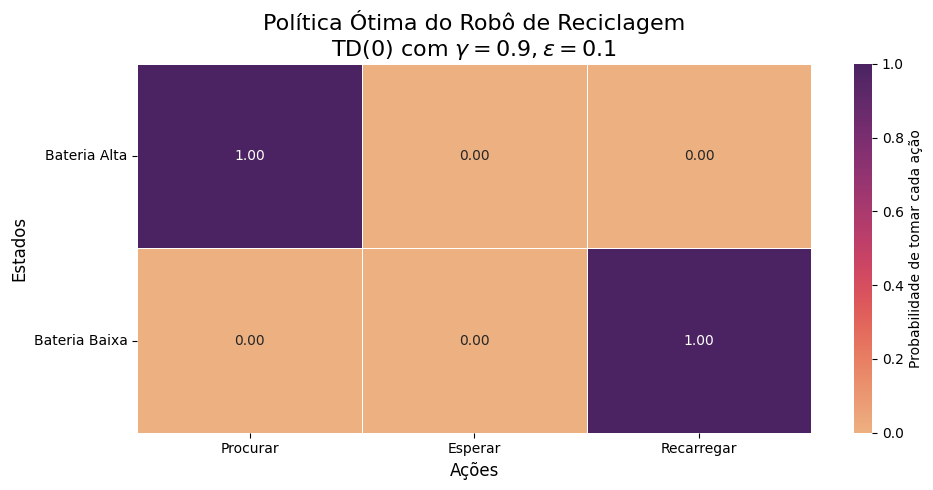

In [67]:
np.random.seed(10)

# Hiperparâmetros do Agente
DISCOUNT_FACTOR = 0.9 # Fator de desconto (gamma)
EPSILON = 0.1         # Probabilidade de exploração (ação aleatória)

REWARD_FILE = "rewards_TD_1.txt"    # Arquivo para salvar as recompensas em rodada única

# Treinando
policy = train(discount_factor=DISCOUNT_FACTOR, epsilon=EPSILON, algorithm="TD", reward_file=REWARD_FILE)
plot_rewards(reward_file=REWARD_FILE, name="rewards_plot_TD_1.png")
plot_policy_heatmap(policy, DISCOUNT_FACTOR, EPSILON, algorithm="TD", name="heatmap_TD_1.png")

## a) $\varepsilon$-greedy vs greedy

### i. $\varepsilon$-greedy com $\varepsilon = 0.1$ e $\gamma = 0.9$

Iniciando o treinamento...
Época 10/100 | Recompensa Total: 6990
Época 20/100 | Recompensa Total: 6915
Época 30/100 | Recompensa Total: 6902
Época 40/100 | Recompensa Total: 6992
Época 50/100 | Recompensa Total: 6974
Época 60/100 | Recompensa Total: 7039
Época 70/100 | Recompensa Total: 7118
Época 80/100 | Recompensa Total: 7005
Época 90/100 | Recompensa Total: 6943
Época 100/100 | Recompensa Total: 7114
Política salva em policy_td0.pkl
Treinamento concluído.
Gráfico de recompensas salvo em 'figs/rewards_plot_TD_1.png'
Heatmap da política salvo em 'figs/heatmap_TD_1.png'
Iniciando o treinamento...
Época 10/100 | Recompensa Total: 7019
Época 20/100 | Recompensa Total: 7132
Época 30/100 | Recompensa Total: 7059
Época 40/100 | Recompensa Total: 7020
Época 50/100 | Recompensa Total: 7131
Época 60/100 | Recompensa Total: 7051
Época 70/100 | Recompensa Total: 7095
Época 80/100 | Recompensa Total: 6925
Época 90/100 | Recompensa Total: 7015
Época 100/100 | Recompensa Total: 6985
Política salva

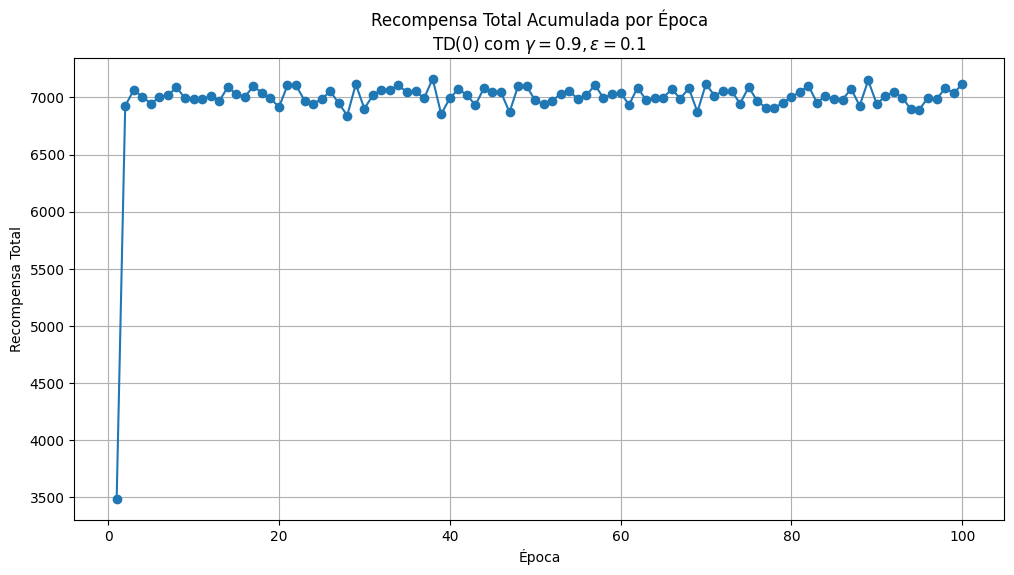

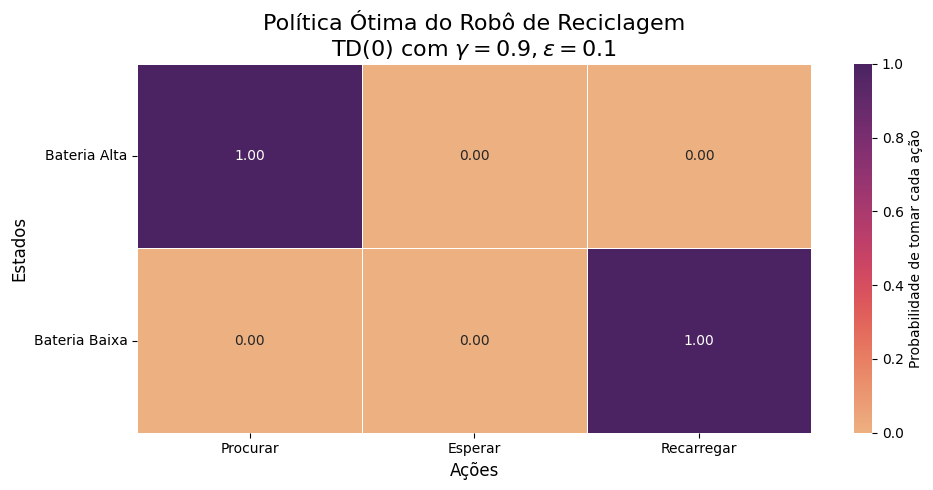

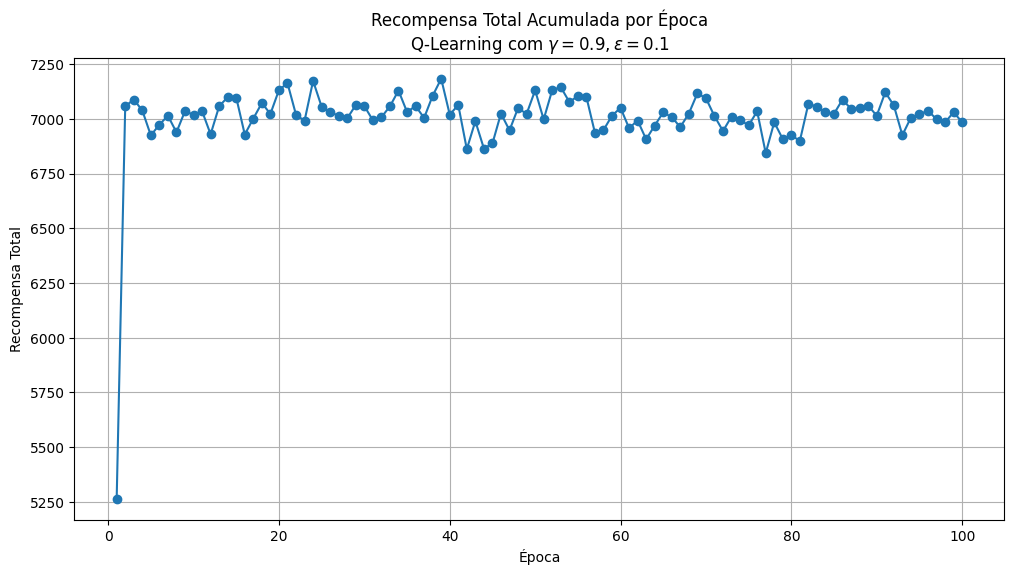

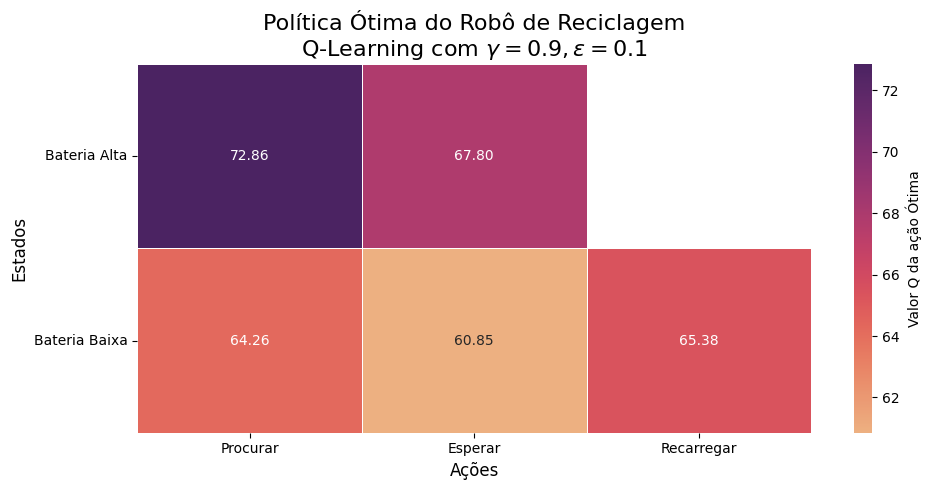

In [80]:
np.random.seed(0)

# Hiperparâmetros do Agente
DISCOUNT_FACTOR = 0.9 # Fator de desconto (gamma)
EPSILON = 0.1         # Probabilidade de exploração (ação aleatória)

REWARD_FILE_TD = "rewards_TD_1.txt"    # Arquivos para salvar as recompensas em rodada única
REWARD_FILE_Q = "rewards_Q_1.txt"      # para cada algoritmo

# Treinando TD(0)
final_values = train(discount_factor=DISCOUNT_FACTOR, algorithm="TD", epsilon=EPSILON, reward_file=REWARD_FILE_TD)
plot_rewards(gamma=DISCOUNT_FACTOR, epsilon=EPSILON, algorithm="TD", reward_file=REWARD_FILE_TD, name="rewards_plot_TD_1.png")
plot_policy_heatmap(final_values, DISCOUNT_FACTOR, EPSILON, algorithm="TD", name="heatmap_TD_1.png")

# Treinando Q-learning
final_values = train(discount_factor=DISCOUNT_FACTOR, algorithm="Q", epsilon=EPSILON, reward_file=REWARD_FILE_Q)
plot_rewards(gamma=DISCOUNT_FACTOR, epsilon=EPSILON, algorithm="Q", reward_file=REWARD_FILE_Q, name="rewards_plot_Q_1.png")
plot_policy_heatmap(final_values, DISCOUNT_FACTOR, EPSILON, algorithm="Q", name="heatmap_Q_1.png")

### ii. Greedy com $\gamma = 0.9$

Iniciando o treinamento...
Época 10/100 | Recompensa Total: 7152
Época 20/100 | Recompensa Total: 7344
Época 30/100 | Recompensa Total: 7248
Época 40/100 | Recompensa Total: 7208
Época 50/100 | Recompensa Total: 7320
Época 60/100 | Recompensa Total: 7280
Época 70/100 | Recompensa Total: 7192
Época 80/100 | Recompensa Total: 7232
Época 90/100 | Recompensa Total: 7152
Época 100/100 | Recompensa Total: 7360
Política salva em policy_td0.pkl
Treinamento concluído.
Gráfico de recompensas salvo em 'figs/rewards_plot_TD_2.png'
Heatmap da política salvo em 'figs/heatmap_TD_2.png'
Iniciando o treinamento...
Época 10/100 | Recompensa Total: 7087
Época 20/100 | Recompensa Total: 7164
Época 30/100 | Recompensa Total: 7131
Época 40/100 | Recompensa Total: 7186
Época 50/100 | Recompensa Total: 7241
Época 60/100 | Recompensa Total: 7131
Época 70/100 | Recompensa Total: 7142
Época 80/100 | Recompensa Total: 7296
Época 90/100 | Recompensa Total: 7197
Época 100/100 | Recompensa Total: 7043
Política salva

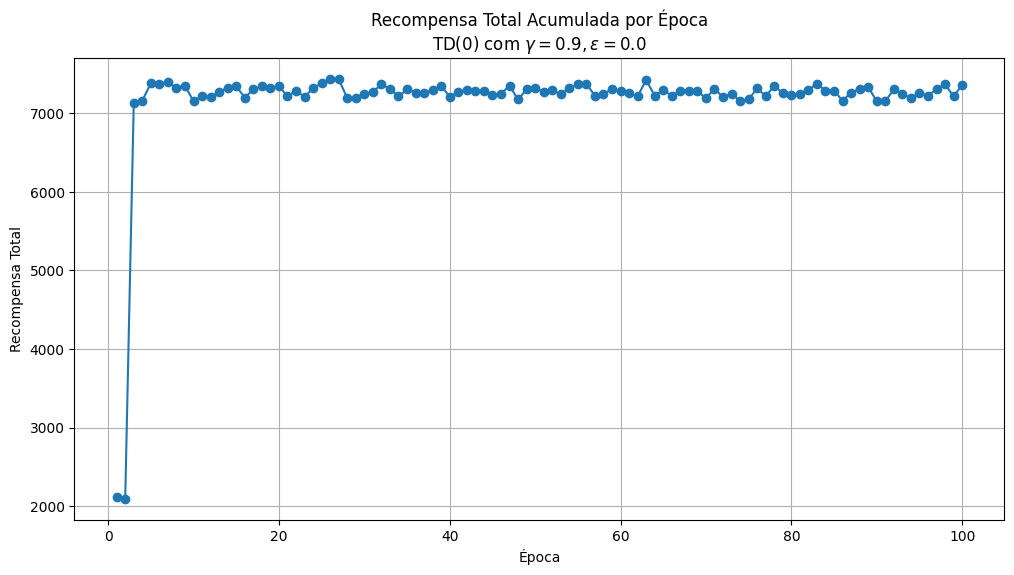

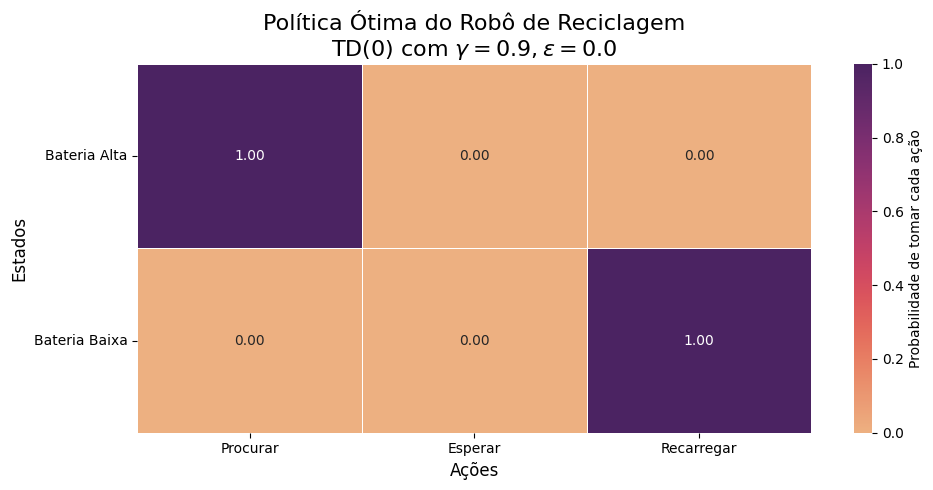

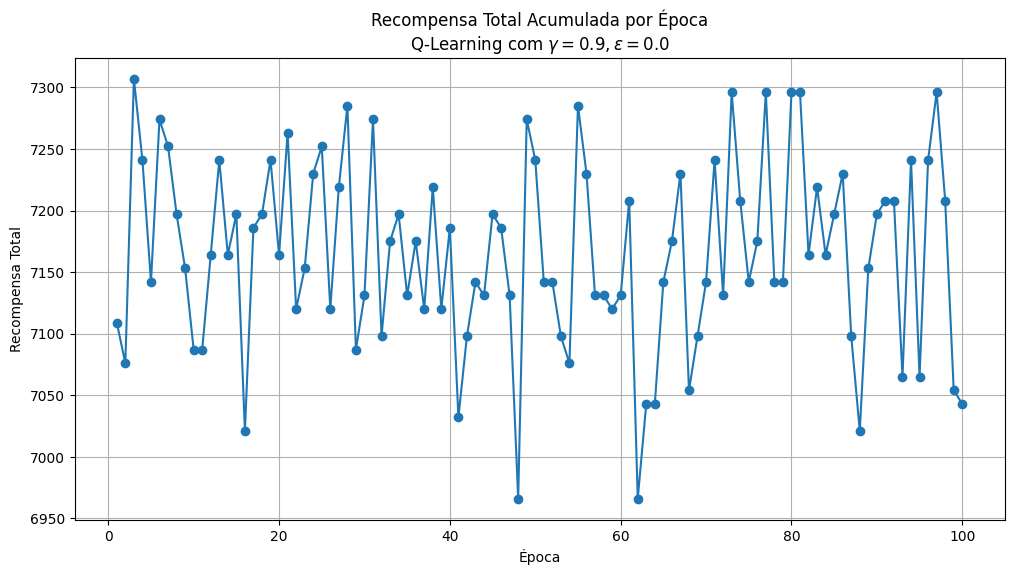

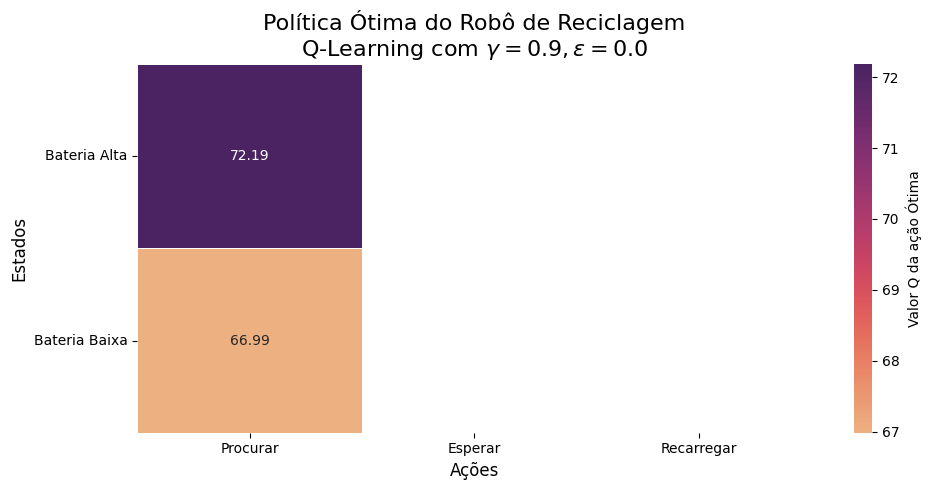

In [81]:
np.random.seed(0)

# Hiperparâmetros do Agente
DISCOUNT_FACTOR = 0.9 # Fator de desconto (gamma)
EPSILON = 0.0         # Probabilidade de exploração (ação aleatória)

REWARD_FILE_TD = "rewards_TD_2.txt"    # Arquivos para salvar as recompensas em rodada única
REWARD_FILE_Q = "rewards_Q_2.txt"      # para cada algoritmo

# Treinando TD(0)
final_values = train(discount_factor=DISCOUNT_FACTOR, algorithm="TD", epsilon=EPSILON, reward_file=REWARD_FILE_TD)
plot_rewards(gamma=DISCOUNT_FACTOR, epsilon=EPSILON, algorithm="TD", reward_file=REWARD_FILE_TD, name="rewards_plot_TD_2.png")
plot_policy_heatmap(final_values, DISCOUNT_FACTOR, EPSILON, algorithm="TD", name="heatmap_TD_2.png")

# Treinando Q-learning
final_values = train(discount_factor=DISCOUNT_FACTOR, algorithm="Q", epsilon=EPSILON, reward_file=REWARD_FILE_Q)
plot_rewards(gamma=DISCOUNT_FACTOR, epsilon=EPSILON, algorithm="Q", reward_file=REWARD_FILE_Q, name="rewards_plot_Q_2.png")
plot_policy_heatmap(final_values, DISCOUNT_FACTOR, EPSILON, algorithm="Q", name="heatmap_Q_2.png")

Nota-se que, como $\varepsilon=0$, não houve exploração, então o agente sequer passou por todas as ações possíveis.

### iii. $\varepsilon$-greedy com $\varepsilon = 0.25$ e $\gamma = 0.1$

Iniciando o treinamento...
Época 10/100 | Recompensa Total: 6658
Época 20/100 | Recompensa Total: 6584
Época 30/100 | Recompensa Total: 6664
Época 40/100 | Recompensa Total: 6688
Época 50/100 | Recompensa Total: 6639
Época 60/100 | Recompensa Total: 6549
Época 70/100 | Recompensa Total: 6707
Época 80/100 | Recompensa Total: 6555
Época 90/100 | Recompensa Total: 6729
Época 100/100 | Recompensa Total: 6597
Política salva em policy_td0.pkl
Treinamento concluído.
Gráfico de recompensas salvo em 'figs/rewards_plot_TD_3.png'
Heatmap da política salvo em 'figs/heatmap_TD_3.png'
Iniciando o treinamento...
Época 10/100 | Recompensa Total: 6776
Época 20/100 | Recompensa Total: 6721
Época 30/100 | Recompensa Total: 6560
Época 40/100 | Recompensa Total: 6531
Época 50/100 | Recompensa Total: 6650
Época 60/100 | Recompensa Total: 6607
Época 70/100 | Recompensa Total: 6704
Época 80/100 | Recompensa Total: 6454
Época 90/100 | Recompensa Total: 6706
Época 100/100 | Recompensa Total: 6681
Política salva

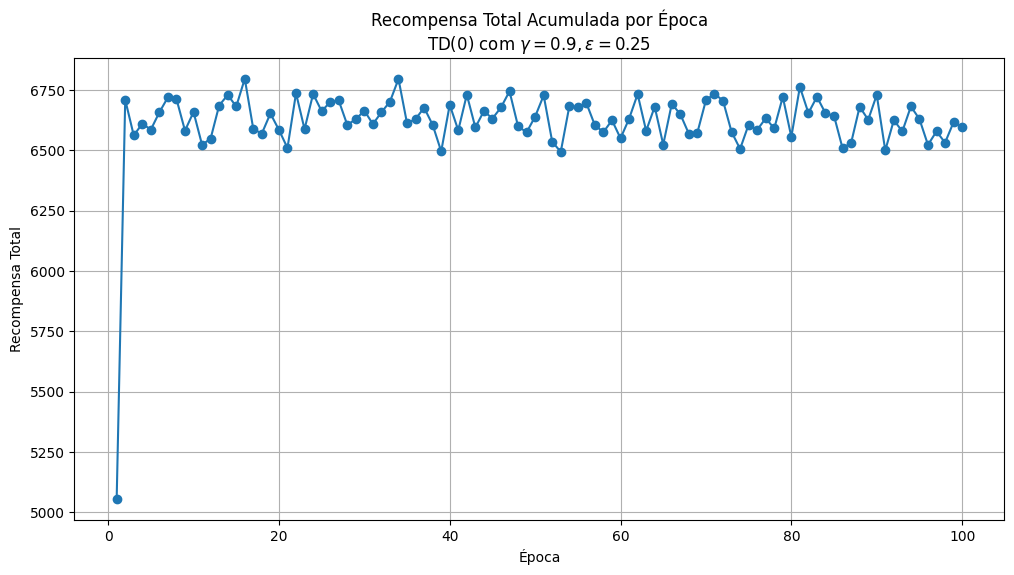

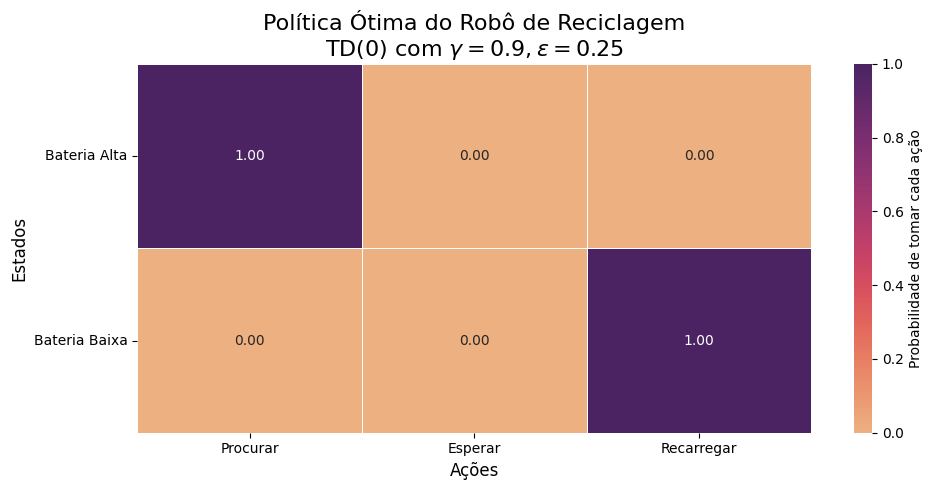

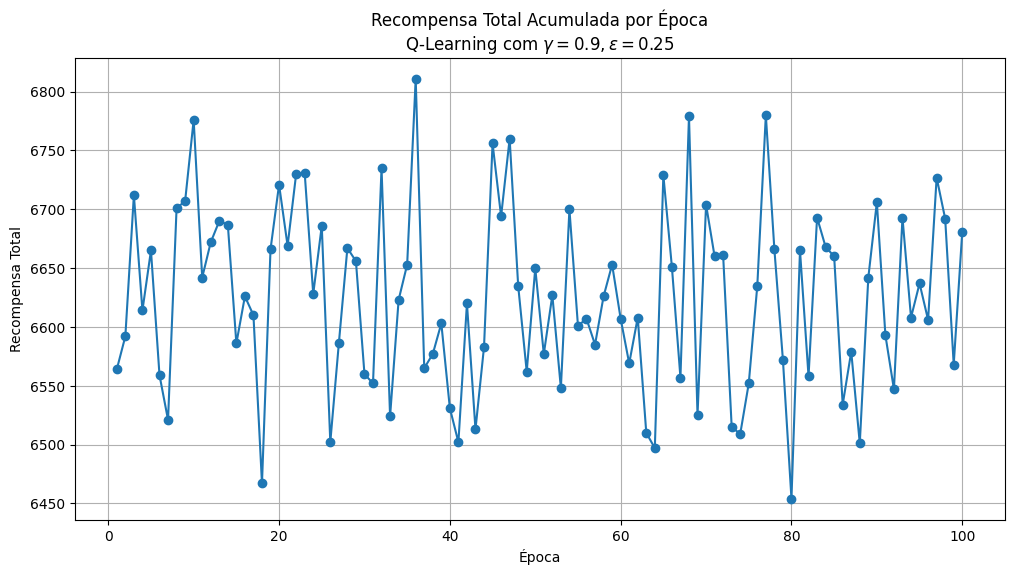

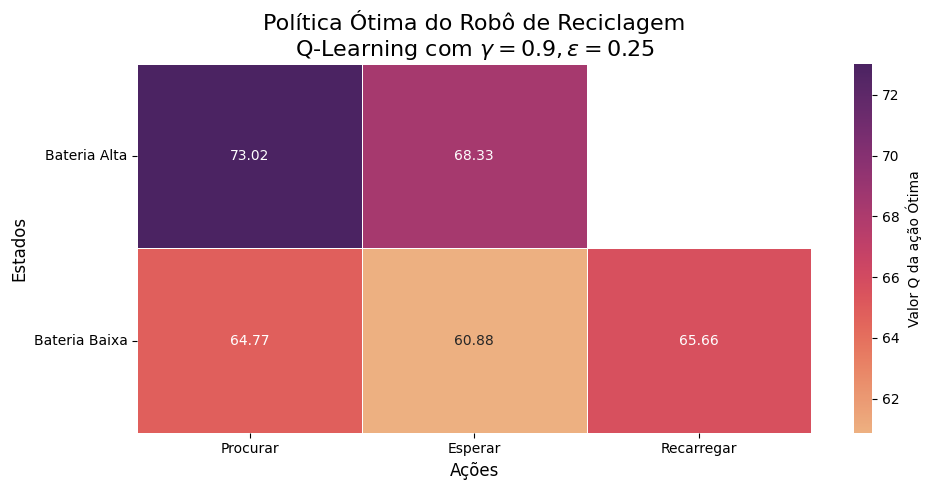

In [82]:
np.random.seed(0)

# Hiperparâmetros do Agente
DISCOUNT_FACTOR = 0.9 # Fator de desconto (gamma)
EPSILON = 0.25         # Probabilidade de exploração (ação aleatória)

REWARD_FILE_TD = "rewards_TD_3.txt"    # Arquivos para salvar as recompensas em rodada única
REWARD_FILE_Q = "rewards_Q_3.txt"      # para cada algoritmo

# Treinando TD(0)
final_values = train(discount_factor=DISCOUNT_FACTOR, algorithm="TD", epsilon=EPSILON, reward_file=REWARD_FILE_TD)
plot_rewards(gamma=DISCOUNT_FACTOR, epsilon=EPSILON, algorithm="TD", reward_file=REWARD_FILE_TD, name="rewards_plot_TD_3.png")
plot_policy_heatmap(final_values, DISCOUNT_FACTOR, EPSILON, algorithm="TD", name="heatmap_TD_3.png")

# Treinando Q-learning
final_values = train(discount_factor=DISCOUNT_FACTOR, algorithm="Q", epsilon=EPSILON, reward_file=REWARD_FILE_Q)
plot_rewards(gamma=DISCOUNT_FACTOR, epsilon=EPSILON, algorithm="Q", reward_file=REWARD_FILE_Q, name="rewards_plot_Q_3.png")
plot_policy_heatmap(final_values, DISCOUNT_FACTOR, EPSILON, algorithm="Q", name="heatmap_Q_3.png")

Aumentando a probabilidade $\varepsilon$ de exploração para 0.25, notamos que o agente se arrisca mais, o que se reflete no fato de que a escolha entre "procurar" e "recarregar" é mais acirrada. Além disso, o histórico de rewards oscila bem mais que no caso $\varepsilon = 0.1$.

## b) Diferentes _discount factors_

### i. $\varepsilon$-greedy com $\varepsilon = 0.1$ e $\gamma = 0.5$

Iniciando o treinamento...
Época 10/100 | Recompensa Total: 6990
Época 20/100 | Recompensa Total: 6915
Época 30/100 | Recompensa Total: 6902
Época 40/100 | Recompensa Total: 6992
Época 50/100 | Recompensa Total: 6974
Época 60/100 | Recompensa Total: 7039
Época 70/100 | Recompensa Total: 7118
Época 80/100 | Recompensa Total: 7005
Época 90/100 | Recompensa Total: 6943
Época 100/100 | Recompensa Total: 7114
Política salva em policy_td0.pkl
Treinamento concluído.
Gráfico de recompensas salvo em 'figs/rewards_plot_TD_4.png'
Heatmap da política salvo em 'figs/heatmap_TD_4.png'
Iniciando o treinamento...
Época 10/100 | Recompensa Total: 6885
Época 20/100 | Recompensa Total: 7069
Época 30/100 | Recompensa Total: 6967
Época 40/100 | Recompensa Total: 6912
Época 50/100 | Recompensa Total: 6900
Época 60/100 | Recompensa Total: 6951
Época 70/100 | Recompensa Total: 7011
Época 80/100 | Recompensa Total: 6925
Época 90/100 | Recompensa Total: 6866
Época 100/100 | Recompensa Total: 7039
Política salva

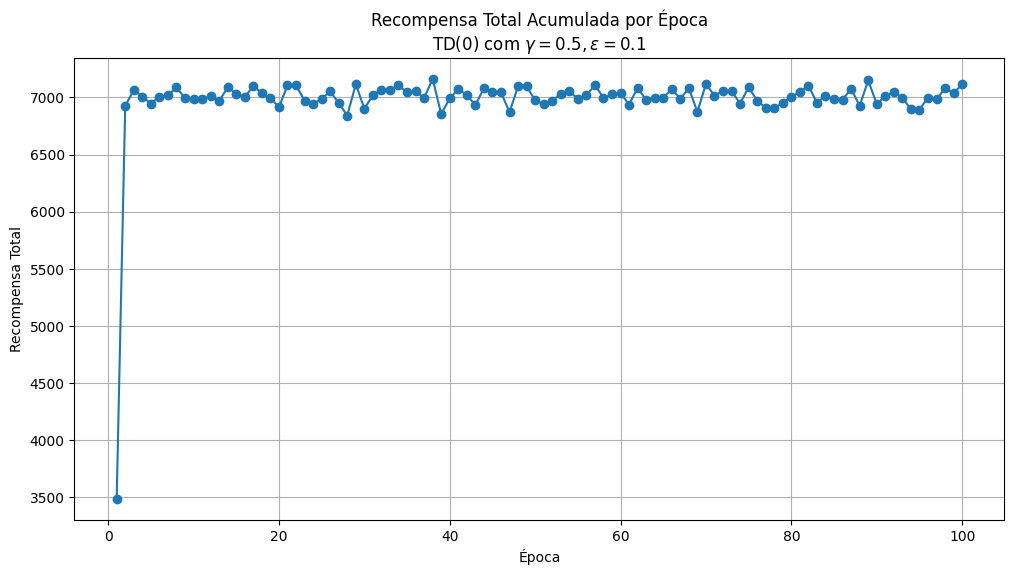

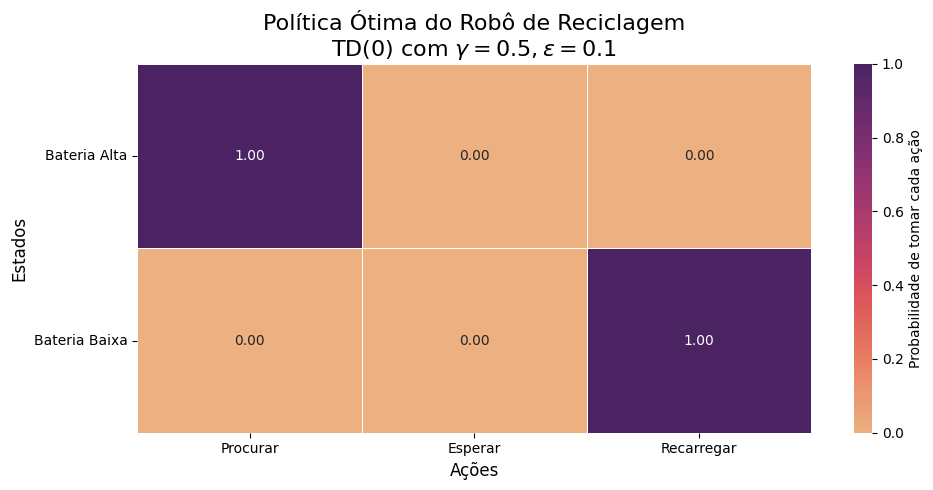

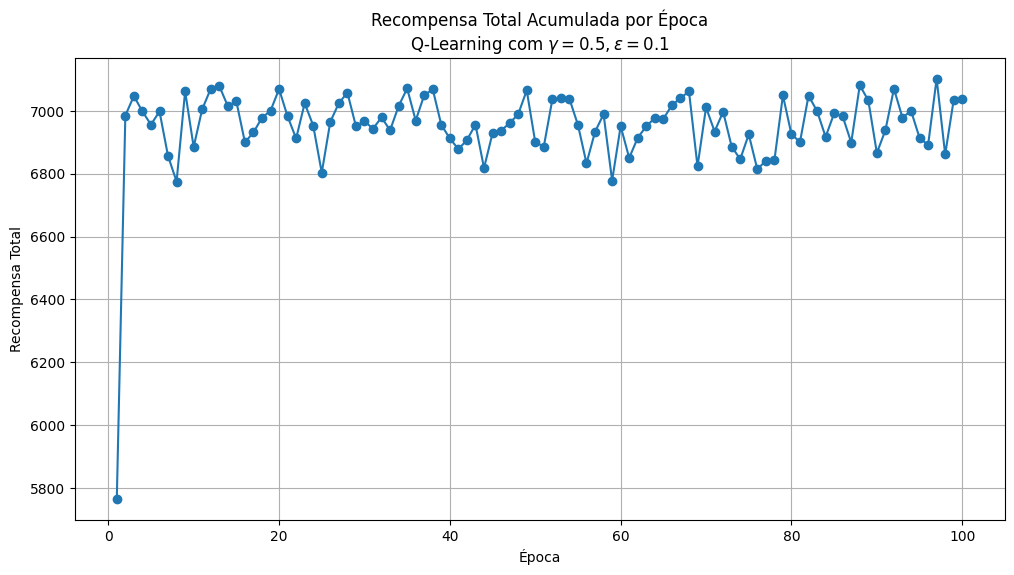

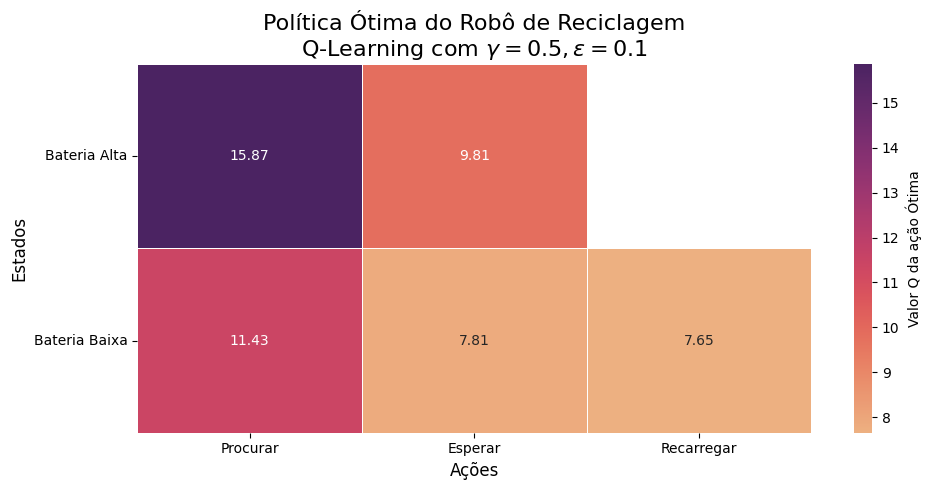

In [83]:
np.random.seed(0)

# Hiperparâmetros do Agente
DISCOUNT_FACTOR = 0.5 # Fator de desconto (gamma)
EPSILON = 0.1         # Probabilidade de exploração (ação aleatória)

REWARD_FILE_TD = "rewards_TD_4.txt"    # Arquivos para salvar as recompensas em rodada única
REWARD_FILE_Q = "rewards_Q_4.txt"      # para cada algoritmo

# Treinando TD(0)
final_values = train(discount_factor=DISCOUNT_FACTOR, algorithm="TD", epsilon=EPSILON, reward_file=REWARD_FILE_TD)
plot_rewards(gamma=DISCOUNT_FACTOR, epsilon=EPSILON, algorithm="TD", reward_file=REWARD_FILE_TD, name="rewards_plot_TD_4.png")
plot_policy_heatmap(final_values, DISCOUNT_FACTOR, EPSILON, algorithm="TD", name="heatmap_TD_4.png")

# Treinando Q-learning
final_values = train(discount_factor=DISCOUNT_FACTOR, algorithm="Q", epsilon=EPSILON, reward_file=REWARD_FILE_Q)
plot_rewards(gamma=DISCOUNT_FACTOR, epsilon=EPSILON, algorithm="Q", reward_file=REWARD_FILE_Q, name="rewards_plot_Q_4.png")
plot_policy_heatmap(final_values, DISCOUNT_FACTOR, EPSILON, algorithm="Q", name="heatmap_Q_4.png")

### ii. $\varepsilon$-greedy com $\varepsilon = 0.1$ e $\gamma = 0.8$

Iniciando o treinamento...
Época 10/100 | Recompensa Total: 6990
Época 20/100 | Recompensa Total: 6915
Época 30/100 | Recompensa Total: 6902
Época 40/100 | Recompensa Total: 6992
Época 50/100 | Recompensa Total: 6974
Época 60/100 | Recompensa Total: 7039
Época 70/100 | Recompensa Total: 7118
Época 80/100 | Recompensa Total: 7005
Época 90/100 | Recompensa Total: 6943
Época 100/100 | Recompensa Total: 7114
Política salva em policy_td0.pkl
Treinamento concluído.
Gráfico de recompensas salvo em 'figs/rewards_plot_TD_5.png'
Heatmap da política salvo em 'figs/heatmap_TD_5.png'
Iniciando o treinamento...
Época 10/100 | Recompensa Total: 7035
Época 20/100 | Recompensa Total: 7159
Época 30/100 | Recompensa Total: 6913
Época 40/100 | Recompensa Total: 6961
Época 50/100 | Recompensa Total: 7058
Época 60/100 | Recompensa Total: 7049
Época 70/100 | Recompensa Total: 6858
Época 80/100 | Recompensa Total: 6866
Época 90/100 | Recompensa Total: 7060
Época 100/100 | Recompensa Total: 7044
Política salva

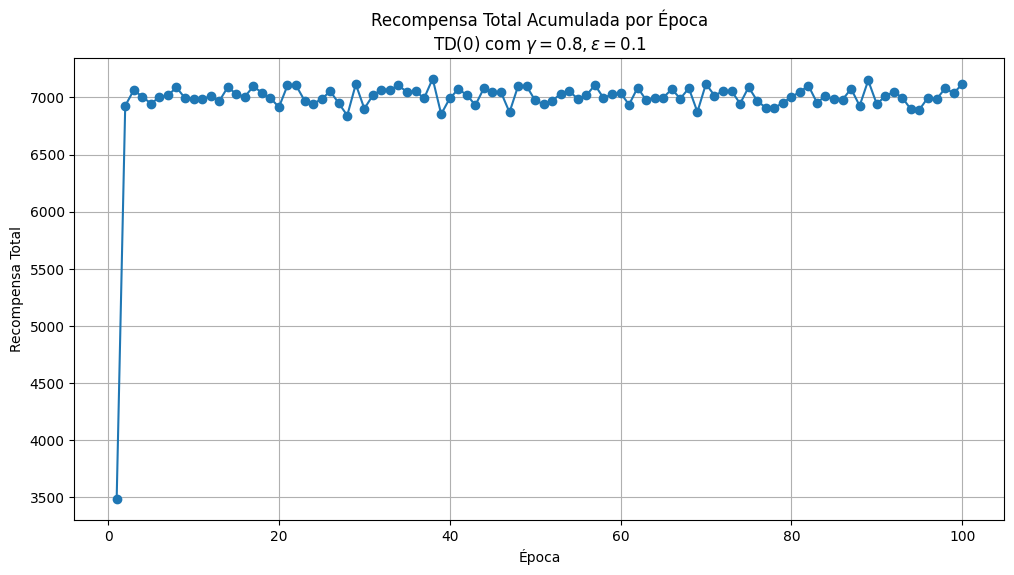

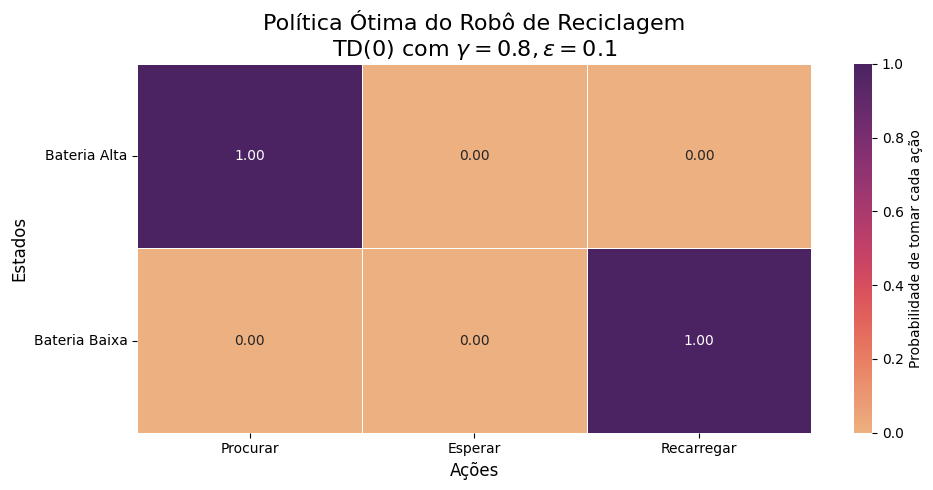

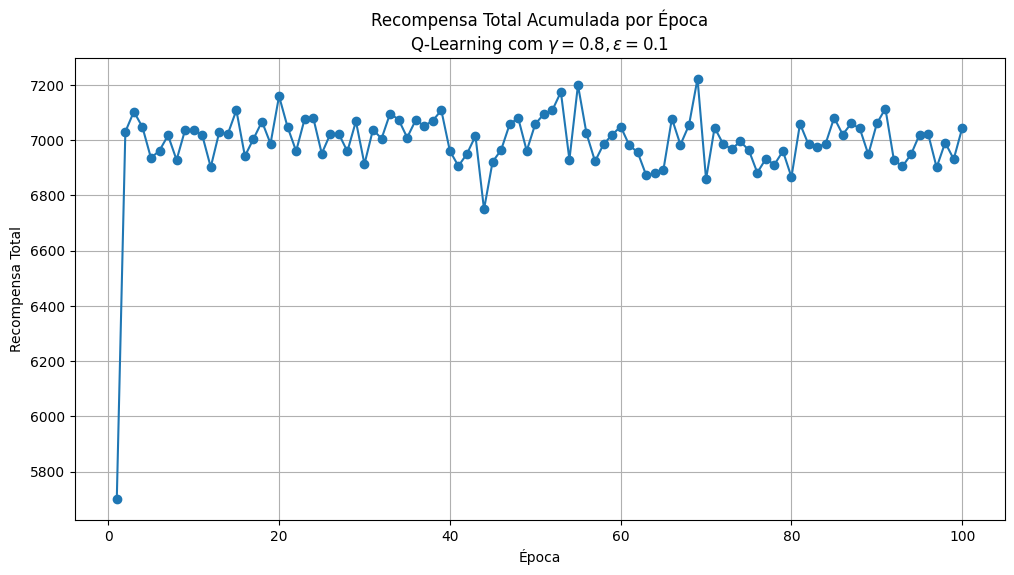

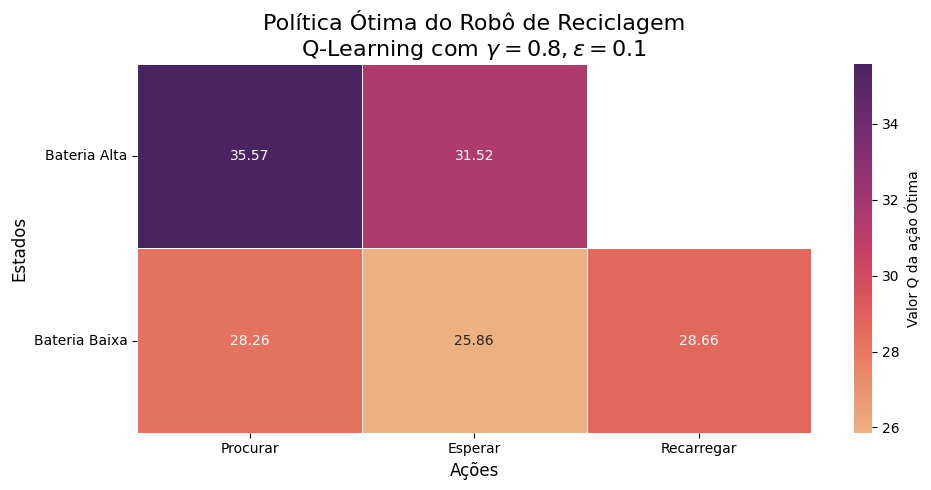

In [84]:
np.random.seed(0)

# Hiperparâmetros do Agente
DISCOUNT_FACTOR = 0.8 # Fator de desconto (gamma)
EPSILON = 0.1         # Probabilidade de exploração (ação aleatória)

REWARD_FILE_TD = "rewards_TD_5.txt"    # Arquivos para salvar as recompensas em rodada única
REWARD_FILE_Q = "rewards_Q_5.txt"      # para cada algoritmo

# Treinando TD(0)
final_values = train(discount_factor=DISCOUNT_FACTOR, algorithm="TD", epsilon=EPSILON, reward_file=REWARD_FILE_TD)
plot_rewards(gamma=DISCOUNT_FACTOR, epsilon=EPSILON, algorithm="TD", reward_file=REWARD_FILE_TD, name="rewards_plot_TD_5.png")
plot_policy_heatmap(final_values, DISCOUNT_FACTOR, EPSILON, algorithm="TD", name="heatmap_TD_5.png")

# Treinando Q-learning
final_values = train(discount_factor=DISCOUNT_FACTOR, algorithm="Q", epsilon=EPSILON, reward_file=REWARD_FILE_Q)
plot_rewards(gamma=DISCOUNT_FACTOR, epsilon=EPSILON, algorithm="Q", reward_file=REWARD_FILE_Q, name="rewards_plot_Q_5.png")
plot_policy_heatmap(final_values, DISCOUNT_FACTOR, EPSILON, algorithm="Q", name="heatmap_Q_5.png")

### iii. $\varepsilon$-greedy com $\varepsilon = 0.1$ e $\gamma = 0.99$

Iniciando o treinamento...
Época 10/100 | Recompensa Total: 6990
Época 20/100 | Recompensa Total: 6915
Época 30/100 | Recompensa Total: 6902
Época 40/100 | Recompensa Total: 6992
Época 50/100 | Recompensa Total: 6974
Época 60/100 | Recompensa Total: 7039
Época 70/100 | Recompensa Total: 7118
Época 80/100 | Recompensa Total: 7005
Época 90/100 | Recompensa Total: 6943
Época 100/100 | Recompensa Total: 7114
Política salva em policy_td0.pkl
Treinamento concluído.
Gráfico de recompensas salvo em 'figs/rewards_plot_TD_6.png'
Heatmap da política salvo em 'figs/heatmap_TD_6.png'
Iniciando o treinamento...
Época 10/100 | Recompensa Total: 7001
Época 20/100 | Recompensa Total: 7020
Época 30/100 | Recompensa Total: 7116
Época 40/100 | Recompensa Total: 7030
Época 50/100 | Recompensa Total: 7047
Época 60/100 | Recompensa Total: 7046
Época 70/100 | Recompensa Total: 7126
Época 80/100 | Recompensa Total: 6926
Época 90/100 | Recompensa Total: 6961
Época 100/100 | Recompensa Total: 6989
Política salva

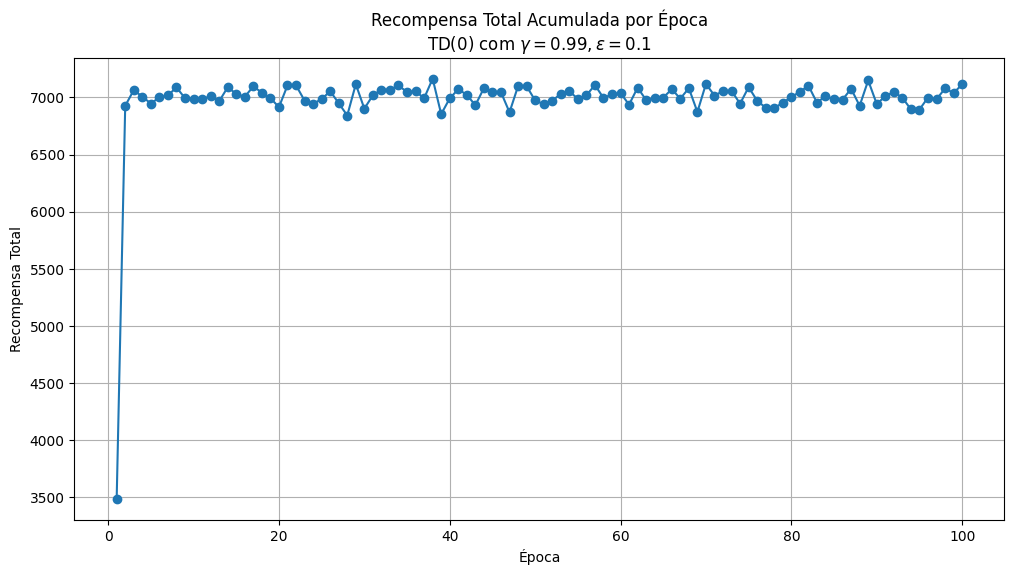

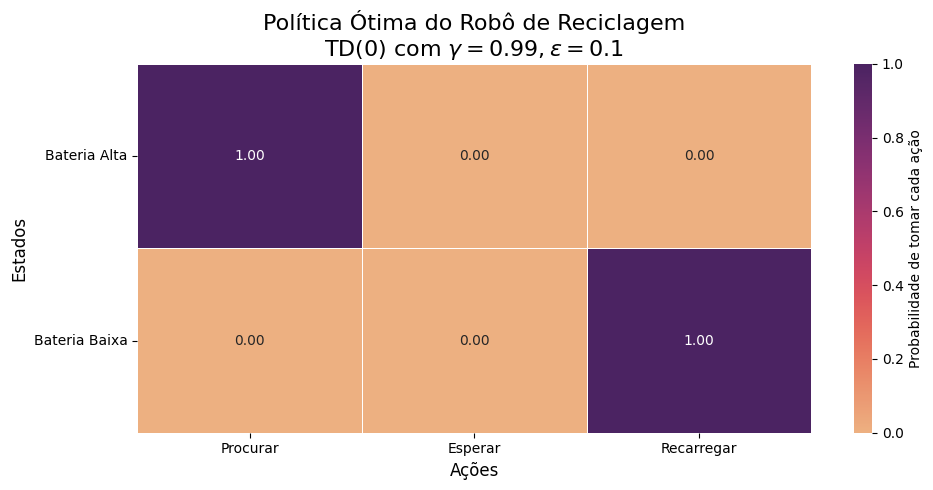

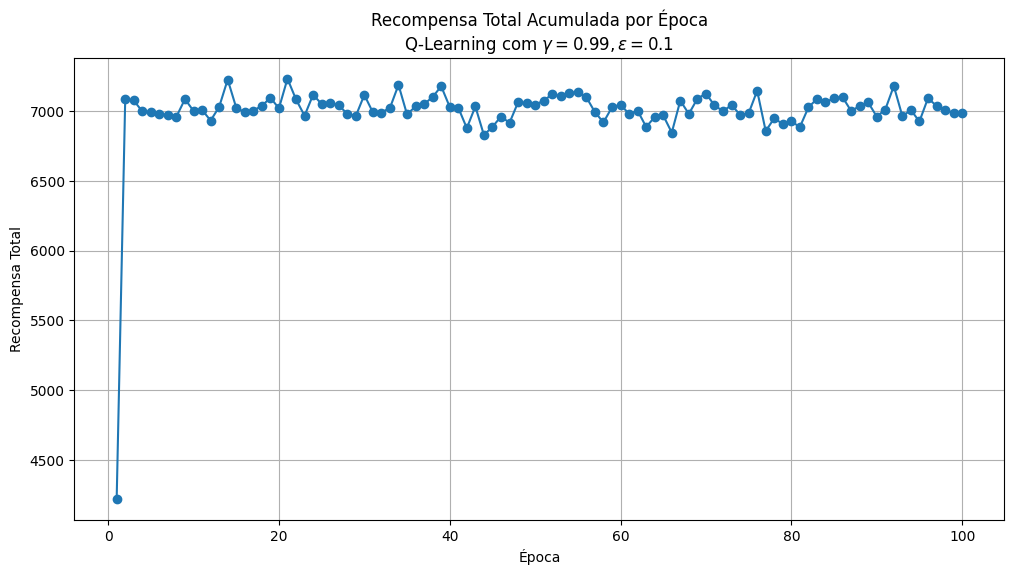

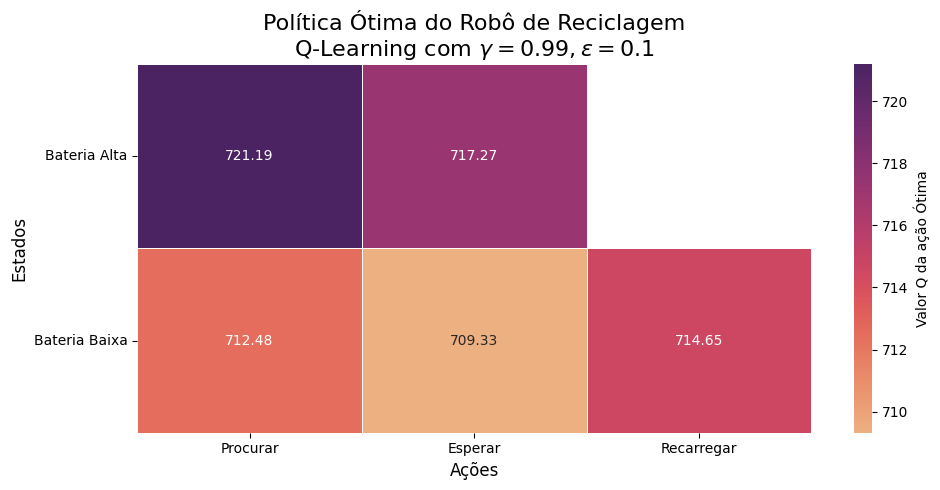

In [85]:
np.random.seed(0)

# Hiperparâmetros do Agente
DISCOUNT_FACTOR = 0.99 # Fator de desconto (gamma)
EPSILON = 0.1         # Probabilidade de exploração (ação aleatória)

REWARD_FILE_TD = "rewards_TD_6.txt"    # Arquivos para salvar as recompensas em rodada única
REWARD_FILE_Q = "rewards_Q_6.txt"      # para cada algoritmo

# Treinando TD(0)
final_values = train(discount_factor=DISCOUNT_FACTOR, algorithm="TD", epsilon=EPSILON, reward_file=REWARD_FILE_TD)
plot_rewards(gamma=DISCOUNT_FACTOR, epsilon=EPSILON, algorithm="TD", reward_file=REWARD_FILE_TD, name="rewards_plot_TD_6.png")
plot_policy_heatmap(final_values, DISCOUNT_FACTOR, EPSILON, algorithm="TD", name="heatmap_TD_6.png")

# Treinando Q-learning
final_values = train(discount_factor=DISCOUNT_FACTOR, algorithm="Q", epsilon=EPSILON, reward_file=REWARD_FILE_Q)
plot_rewards(gamma=DISCOUNT_FACTOR, epsilon=EPSILON, algorithm="Q", reward_file=REWARD_FILE_Q, name="rewards_plot_Q_6.png")
plot_policy_heatmap(final_values, DISCOUNT_FACTOR, EPSILON, algorithm="Q", name="heatmap_Q_6.png")

---